## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [151]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/Users/ctang/Desktop/ECE_C147/HW2/cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [154]:
from nndl import Softmax

In [155]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [157]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [158]:
print(loss)

2.327760702804897


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

Since there is no training initially done on the softmax, the weights are thus initialized to 0. The value of teh loss according to the softmax function would thus be: 
-1/m*log((1/10)^m) = log(10)
If we calculate log(10) this is approximately 2.3.

#### Softmax gradient

In [162]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 0.065794 analytic: 0.065794, relative error: 3.978329e-07
numerical: 1.995329 analytic: 1.995328, relative error: 5.845017e-09
numerical: -0.662157 analytic: -0.662157, relative error: 3.382267e-08
numerical: 3.587894 analytic: 3.587894, relative error: 1.091485e-09
numerical: 0.128995 analytic: 0.128995, relative error: 2.967061e-07
numerical: 1.805927 analytic: 1.805927, relative error: 3.963822e-09
numerical: -0.838307 analytic: -0.838307, relative error: 2.229423e-08
numerical: 0.713717 analytic: 0.713717, relative error: 2.178844e-08
numerical: 2.445748 analytic: 2.445748, relative error: 1.080725e-08
numerical: -1.755214 analytic: -1.755214, relative error: 2.625190e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [164]:
import time

In [165]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3394135932092235 / 316.52019837143916 computed in 0.08342981338500977s
Vectorized loss / grad: 2.339413593209225 / 313.92404339191137 computed in 0.019639968872070312s
difference in loss / grad: -1.3322676295501878e-15 /124.94010527006971 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.335329533206115
iteration 100 / 1500: loss 2.0748127239245715
iteration 200 / 1500: loss 1.9590764078266198
iteration 300 / 1500: loss 1.8939027531776589
iteration 400 / 1500: loss 1.89399270696175
iteration 500 / 1500: loss 1.867077234226302
iteration 600 / 1500: loss 1.7879467849732493
iteration 700 / 1500: loss 1.9454881111874278
iteration 800 / 1500: loss 1.9144821020559457
iteration 900 / 1500: loss 1.8456003612977296
iteration 1000 / 1500: loss 1.7993233476102852
iteration 1100 / 1500: loss 1.7629753346623744
iteration 1200 / 1500: loss 1.8051228568459141
iteration 1300 / 1500: loss 1.8139940226314408
iteration 1400 / 1500: loss 1.8680936110335444
That took 3.854673147201538s


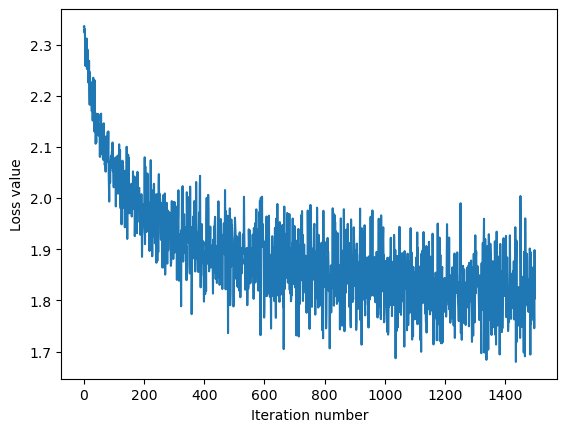

In [189]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, num_iters=1500,verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [206]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.38157142857142856
validation accuracy: 0.386


## Optimize the softmax classifier

In [239]:
np.finfo(float).eps

2.220446049250313e-16

In [241]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
learning_rates = np.linspace(2, -8, 12)
learning_rates = 10**diff_learning_rates
print(learning_rates)

num_iters = 1500
num_rates = len(learning_rates)
loss_records = np.zeros((num_rates, num_iters), dtype=float)
validations = np.zeros(num_rates, dtype=float)
for i in range(num_rates):
    loss_records[i] = softmax.train(X_train, y_train, learning_rate=learning_rates[i],
                                    num_iters=num_iters, verbose=True)
    y_pred = softmax.predict(X_val)
    accuracy = np.mean(y_pred == y_val)
    validations[i] = accuracy
optimal_learning_rate = learning_rates[np.argmax(validations)]
optimal_accuracy = validations[np.argmax(validations)]
print("Most optimal learning rate: ", optimal_learning_rate)
print("Best validation accuracy: ", optimal_accuracy)
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


[1.00000000e+02 1.23284674e+01 1.51991108e+00 1.87381742e-01
 2.31012970e-02 2.84803587e-03 3.51119173e-04 4.32876128e-05
 5.33669923e-06 6.57933225e-07 8.11130831e-08 1.00000000e-08]
iteration 0 / 1500: loss 2.3662239309805724
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 2.415042735354712
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1

## Comments Regarding the Best Validation Error and Accuracy
According to the output above, the best validation accuracy is when the learning rate is approximately 6.579332246575682e-07 out of the 12 different provided learning rates. The best validation accuracy corresponding to the optimal learning rate was 0.415.